# Import all required library

In [ ]:
%pip install matplotlib pandas numpy seaborn wordcloud

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import facebook_scraper as fs

# Craw comment data

In [ ]:
raw_df = pd.read_csv('Data/perfect_data.csv')
post_ids_comment = np.array(raw_df.loc[raw_df['image'] == True, 'post_id'])

In [ ]:
# Danh sách để lưu trữ dữ liệu comment
all_comments = []

for post_id in post_ids_comment:
    gen = fs.get_posts(
        post_urls=[post_id],
        options={"comments": 27, "progress": True}
    )
    post = next(gen)
    comments = post['comments_full']
    
    # Thu thập thông tin từ mỗi comment và thêm vào danh sách all_comments
    for comment in comments:
        comment_data = {
            'post_id': post_id,
            'comment_id': comment['comment_id'],
            'comment_url': comment['comment_url'],
            'commenter_id': comment['commenter_id'],
            'commenter_name': comment['commenter_name'],
            'comment_text': comment['comment_text'],
            'comment_time' : comment['comment_time']
        }
        all_comments.append(comment_data)


# Tạo DataFrame từ danh sách all_comments
df_comments = pd.DataFrame(all_comments)

# Lưu DataFrame vào file CSV
df_comments.to_csv('Data/comments.csv', index=False)


# Comment analysis

In [68]:
df = pd.read_csv('Data/comments.csv')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post_id         935 non-null    int64 
 1   comment_id      935 non-null    int64 
 2   comment_url     935 non-null    object
 3   commenter_id    935 non-null    int64 
 4   commenter_name  935 non-null    object
 5   comment_text    935 non-null    object
 6   comment_time    934 non-null    object
dtypes: int64(3), object(4)
memory usage: 51.3+ KB


In [26]:
# Tính tổng số lượt bình luận cho mỗi người
comment_counts = df.groupby('commenter_id')['comment_id'].count()

# Lấy top 5 người bình luận nhiều nhất
top_5_commenters = comment_counts.nlargest(5)

# Lấy dataframe chứa thông tin của top 5 người bình luận
top_5_info = df[df['commenter_id'].isin(top_5_commenters.index)]

# In ra tên và số lượt bình luận tương ứng
print("Top 5 người bình luận nhiều nhất:")
print(top_5_info.groupby(['commenter_id', 'commenter_name']).size().reset_index(name='comment_count'))


Top 5 người bình luận nhiều nhất:
      commenter_id           commenter_name  comment_count
0  100006117607164          Rebecca Chituwi             30
1  100007846239202  Md Ziaul Basher Bhuiyan             45
2  100022160513821            Ahmed Abdalla             30
3  100042310539958              Doaa Nasser             55
4  100052464531616            Nishant Kumar             34


In [70]:
# Calculating the length of each post
df['comment_length'] = df['comment_text'].str.len()

In [75]:
print(df['comment_text'].to_string())

0      Greatly appreciate work done by Unicef in prov...
1                                  Proud awareness work🏆
2      It's a huge sad and real story. UNICEF is neve...
3      یو ملی کمپاین پکار دی بایددکنړ اوبه په چټلستان...
4                                             ❤️❤️❤️❤️❤️
5                                            Bien triste
6                  Sad why earthquake always Afghanistan
7      mọi thứ không ổn anh ạ em ốm mệt công việc đìn...
8      Only aware people change the world 🙏\nHope..un...
9               Thanks UNICEF for your awareness work 💕💕
10     Hace un mes 30 niños y bebes rehenes del hamas...
11                               Christophe van den Berg
12     They persecute the displaced in UNRWA schools ...
13                                             SAVE GAZA
14     That's really sad, on the other site people ar...
15                                                   🙏🙏🙏
16                                                     🥰
17     fashi tu sera juge pour 

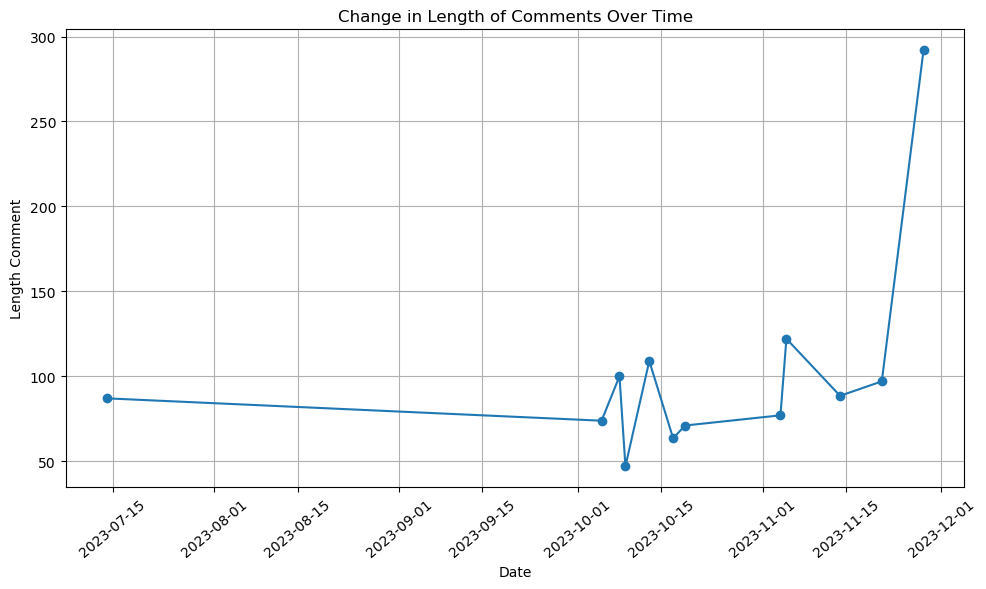

In [74]:
df['comment_time'] = pd.to_datetime(df['comment_time'])
# Group by date and sum the reaction counts
comment_length_by_date = df.groupby(df['comment_time'].dt.date)['comment_length'].mean()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(comment_length_by_date, marker='o', linestyle='-')
plt.title('Change in Length of Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Length Comment')
plt.xticks(rotation=40)
plt.grid(True)
plt.tight_layout()

In [91]:
pip install emoji

  Obtaining dependency information for emoji from https://files.pythonhosted.org/packages/96/c6/0114b2040a96561fd1b44c75df749bbd3c898bf8047fb5ce8d7590d2dee6/emoji-2.8.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/358.9 kB ? eta -:--:--
   --- ------------------------------------ 30.7/358.9 kB ? eta -:--:--
   ------------ --------------------------- 112.6/358.9 kB 1.3 MB/s eta 0:00:01
   ------------------- -------------------- 174.1/358.9 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------  358.4/358.9 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 358.9/358.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [93]:
import pandas as pd
import emoji

# Giả sử df là DataFrame của bạn có cột 'comment_text'
# df = ...

def contains_emoji(comment):
    # Kiểm tra xem comment có chứa ít nhất một emoji không
    return any(emoji.is_emoji(c) for c in comment)

# Lọc DataFrame để giữ lại các hàng không chứa emoji trong cột 'comment_text'
df_no_emoji = df[~df['comment_text'].apply(contains_emoji)]

# In ra DataFrame sau khi lọc
print(df_no_emoji)


             post_id        comment_id                            comment_url  \
0    762758365888751  1513790312728272  https://facebook.com/1513790312728272   
2    762758365888751  1044304133659005  https://facebook.com/1044304133659005   
3    762758365888751  6801136936589257  https://facebook.com/6801136936589257   
5    762758365888751   663469329204669   https://facebook.com/663469329204669   
6    762758365888751   356010096822184   https://facebook.com/356010096822184   
..               ...               ...                                    ...   
925  743860267778561  1353551585580143  https://facebook.com/1353551585580143   
926  743860267778561  1684559778709041  https://facebook.com/1684559778709041   
930  743860267778561  2581666738669596  https://facebook.com/2581666738669596   
932  743860267778561  3515752808742841  https://facebook.com/3515752808742841   
934  743860267778561  2068818490149530  https://facebook.com/2068818490149530   

        commenter_id       

In [95]:
print(df_no_emoji['comment_text'].to_string())

0      Greatly appreciate work done by Unicef in prov...
2      It's a huge sad and real story. UNICEF is neve...
3      یو ملی کمپاین پکار دی بایددکنړ اوبه په چټلستان...
5                                            Bien triste
6                  Sad why earthquake always Afghanistan
7      mọi thứ không ổn anh ạ em ốm mệt công việc đìn...
10     Hace un mes 30 niños y bebes rehenes del hamas...
11                               Christophe van den Berg
12     They persecute the displaced in UNRWA schools ...
13                                             SAVE GAZA
14     That's really sad, on the other site people ar...
17     fashi tu sera juge pour le promese n'ont tenus...
18                                 #savechildrenofg\naza
19     One cant certify them innocent, 46% or more su...
22                                              very sad
23     https://\nwww.facebook.com\n/reel/\n7798837939...
24     https://\nwww.facebook.com\n/reel/\n7100299578...
25     Pakistan does not give a

In [ ]:
pip install langid

In [ ]:
pip install translators

In [85]:
from langid.langid import LanguageIdentifier, model
from translators import translate_text

In [ ]:
def translate_to_english(text, source_lang):
    try:
        # Kiểm tra ngôn ngữ của văn bản
        identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
        detected_lang, _ = identifier.classify(text)

        # Nếu ngôn ngữ khác tiếng Anh, thì dịch văn bản
        if detected_lang != 'en':
            translated_text = translate_text(text, source_lang=detected_lang, target_lang='en')
            return translated_text
        else:
            return text  # Nếu văn bản đã là tiếng Anh, không cần dịch
    except Exception as e:
        print(f"Error translating text: {e}")
        return text

# Áp dụng hàm translate_to_english cho cột 'comment_text'
df['comment_text_english'] = df.apply(lambda row: translate_to_english(row['comment_text'], source_lang='auto'), axis=1)
